In [1]:
#!/usr/bin/python
import numpy as np
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import os
import sys
import pandas as pd

In [2]:
sys.path.append('../python/')
import tools
import scrapers
import models
import plotting
savePath="../figures/"

In [3]:
# scrape data and store as dfs in dict
print("scraping all seasons for all teams...")
dfDict = scrapers.scrape_all_teams(tools.teamList)

scraping all seasons for all teams...
first few rows of an example data frame:
    Season   Lg   Tm   W   L Finish     Age  Ht.  Wt.  ...     FT%   ORB  \
0  2018-19  NBA  CLE  19  63      5    25.2  6-6  214  ...    .792  10.7   
1  2017-18  NBA  CLE  50  32      1    30.6  6-6  227  ...    .779   8.5   
2  2016-17  NBA  CLE  51  31      1    29.2  6-6  228  ...    .748   9.3   
3  2015-16  NBA  CLE  57  25      1    28.1  6-7  231  ...    .748  10.6   
4  2014-15  NBA  CLE  53  29      1    26.9  6-7  225  ...    .751  11.1   

    DRB   TRB   AST  STL  BLK   TOV    PF    PTS  
0  31.9  42.7  20.7  6.5  2.4  13.5  20.0  104.5  
1  33.7  42.1  23.4  7.1  3.8  13.7  18.6  110.9  
2  34.4  43.7  22.7  6.6  4.0  13.7  18.1  110.3  
3  33.9  44.5  22.7  6.7  3.9  13.6  20.3  104.3  
4  31.9  43.0  22.1  7.4  4.1  14.3  18.4  103.1  

[5 rows x 34 columns]


In [4]:
# assemble features in numpy array
featureList = ["W","PTS","2P%","2PA","3P%","3PA","FT%","FTA","ORB","DRB","AST",
               "TOV","STL","BLK","PF","Age","Ht.","Wt."]
idList, npData = models.dict_to_np_teams(dfDict, featureList)
npData         = models.scale_features(npData)

In [5]:
# fit pca and transform data
pca, npDataTrans = models.fit_pca(npData, 0.90)

Using 10 components explaining 90.68268039014688% of variance in original data set


In [6]:
nClusterList = range(1,20)
distSumsList = []
for nClusters in nClusterList:
    # run the alg in the new feature space from the pca
    kmeans = KMeans(n_clusters=nClusters)
    kmeans.fit(npDataTrans)
    # measure the sum of the distances to cluster centers for each kmeans
    totDist = np.sqrt(models.tot_sum_cluster_dists2(npDataTrans, kmeans))
    distSumsList.append(totDist)

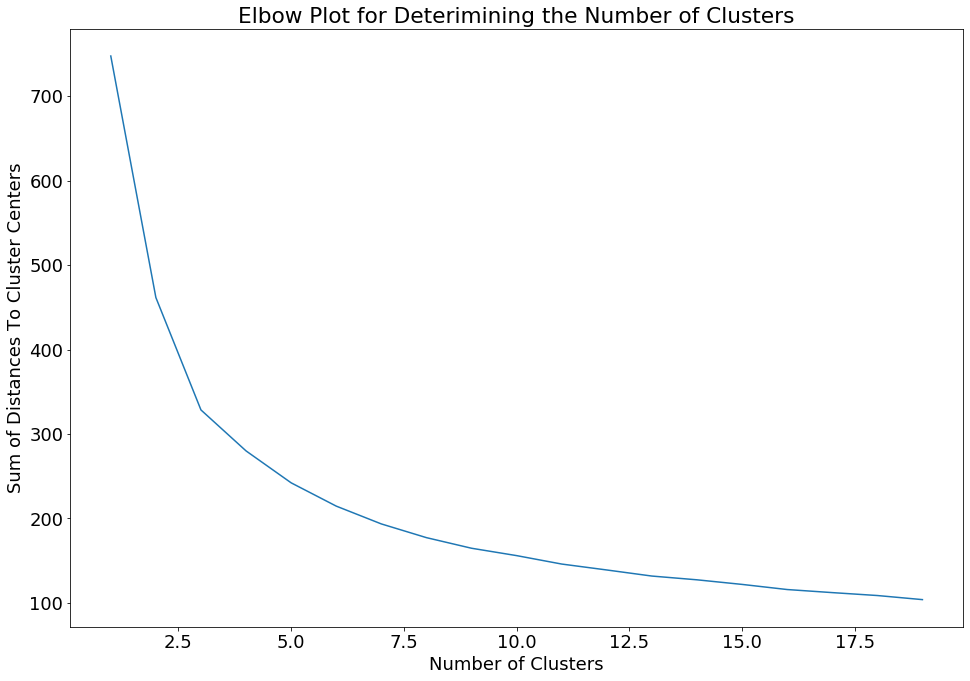

In [7]:
# make an elbow plot to determine the appropriate number of clusters
plt.plot(nClusterList, distSumsList)
plt.ylabel("Sum of Distances To Cluster Centers")
plt.xlabel("Number of Clusters")
plt.title("Elbow Plot for Deterimining the Number of Clusters");

In [8]:
# Use the plot above to select nClusters and do a final kmeans with that parameter
nClusters = 6
kmeans = KMeans(n_clusters=nClusters)
kmeans.fit(npDataTrans);

In [9]:
# List players/seasons closest to cluster centers to find representative players for each cluster
for n in range(nClusters):
    theseIds, sortedDists = models.get_sorted_distances(kmeans.cluster_centers_[n], idList, npDataTrans, 50)
    print(n)
    print(theseIds)
    print("\n")

0
['MIL_1985', 'SAS_1988', 'MIL_1982', 'MIL_1980', 'POR_1983', 'OKC_1982', 'PHO_1982', 'HOU_1989', 'SAS_1983', 'NJN_1985', 'POR_1985', 'PHI_1987', 'POR_1984', 'SAS_1985', 'PHO_1981', 'PHO_1987', 'MIL_1983', 'SAS_1982', 'OKC_1987', 'SAS_1984', 'ATL_1986', 'BOS_1983', 'MIL_1986', 'PHO_1983', 'SAC_1984', 'CLE_1985', 'NJN_1986', 'NYK_1990', 'SAS_1990', 'MIL_1984', 'DET_1987', 'OKC_1980', 'OKC_1983', 'MIL_1981', 'POR_1982', 'LAC_1986', 'DEN_1980', 'CHI_1988', 'HOU_1981', 'HOU_1988', 'BOS_1984', 'SAS_1986', 'UTA_1984', 'GSW_1986', 'ATL_1988', 'SAS_1991', 'OKC_1984', 'PHO_1991', 'OKC_1988', 'SAC_1981']


1
['CHA_2007', 'CHA_2009', 'CHI_2008', 'CHI_2005', 'ATL_2004', 'MIL_2008', 'PHO_2003', 'GSW_2005', 'CHA_2008', 'PHI_2007', 'IND_2007', 'WAS_2011', 'LAC_1998', 'ATL_2002', 'PHI_2009', 'WAS_2009', 'MEM_2000', 'PHI_2010', 'PHI_1996', 'HOU_2000', 'CHI_2003', 'PHO_2004', 'MEM_1998', 'POR_2007', 'DET_2010', 'CHI_2004', 'TOR_2011', 'DEN_2015', 'CHI_2002', 'DET_1998', 'ATL_2001', 'CHI_2006', 'CLE_200

In [10]:
repPlayers = ["Garret Temple 2015 SF/SG", 
              "Victor Oladipo 2015 SG/PG", 
              "Nikola Vucevic 2016 C",
              "Leandro Barbosa 2016 SG/PG", 
              "Adreian Payne 2015 PF", 
              "JR Smith 2011 SG"]

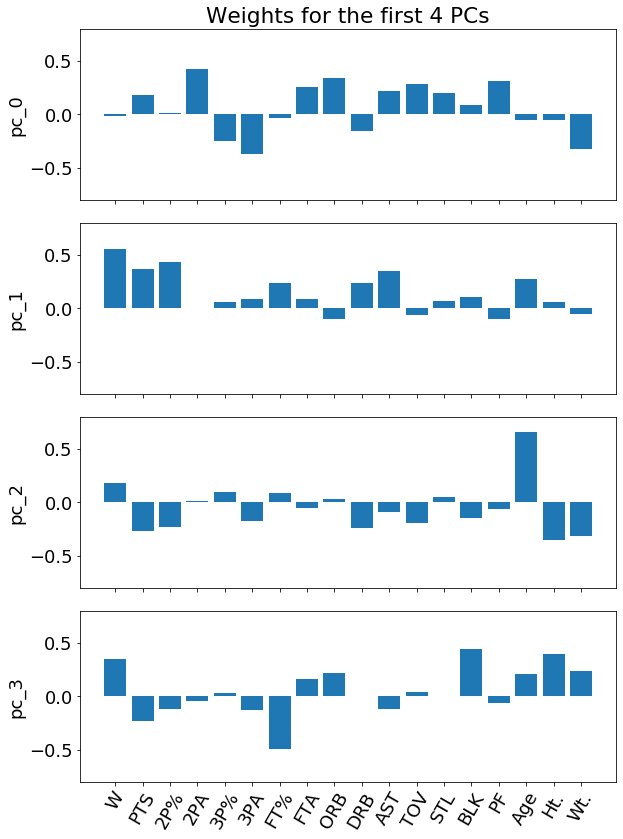

In [11]:
# visualize pca components
plt = plotting.vis_pca(pca, featureList)

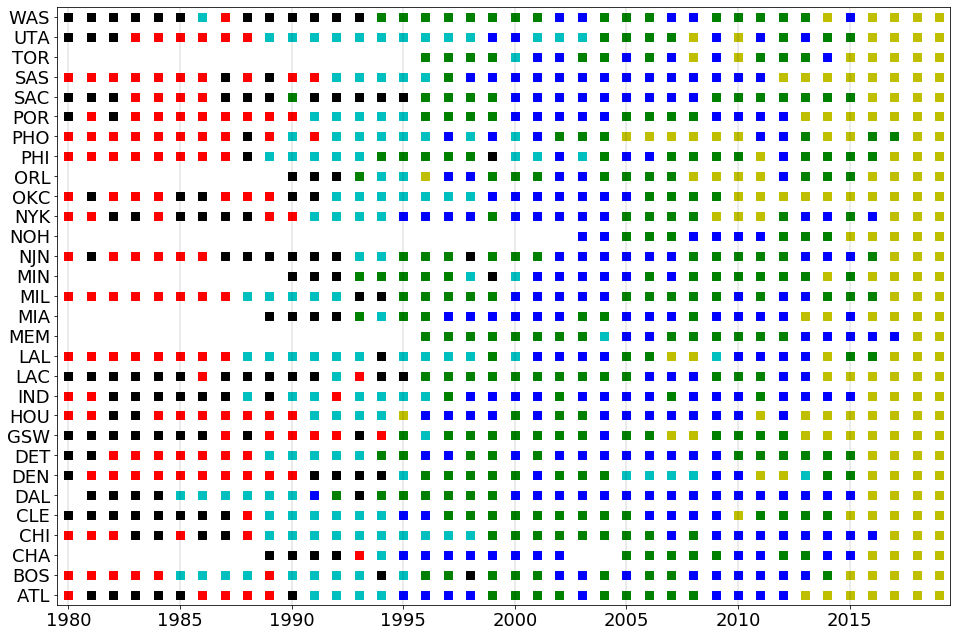

In [15]:
# plot team classifications over the years
plt = plotting.classification_plot_teams(kmeans, npDataTrans, idList)
#plt.savefig(savePath+"team_year.png", dpi=100); plt.clf();

In [13]:
totMean      = np.mean(npDataTrans, axis=0)
weightedData = pca.explained_variance_ratio_[:nFeatures]*npDataTrans
dists        = np.sqrt(np.sum(np.square(weightedData),axis=1))
dists       /= np.mean(dists)
plt.hist(dists, bins=50, log=True, density=True);
plt.xlabel("Normalized Distance from Center");
plt.ylabel("Relative Frequency");

NameError: name 'nFeatures' is not defined

In [ ]:
# take a look at who is at the right end of this distribution
sortArgs = np.flip(np.argsort(dists))
rank = 1
for arg in sortArgs[:20]: 
    print(rank, idList[arg], np.round(dists[arg],2))
    rank+=1

In [ ]:
dists = []
for i in range(nTot):
    center = kmeans.cluster_centers_[kmeans.labels_[i]]
    dists.append(np.sqrt(np.sum(np.square(npDataTrans[i]-center))))
dists  = np.asarray(dists)
dists /= np.mean(dists)

In [ ]:
plt.hist(dists, bins=50, log=True, density=True);
plt.xlabel("Normalized Distance from Center");
plt.ylabel("Relative Frequency");

In [ ]:
# take a look at who is at the right end of this distribution
sortArgs = np.flip(np.argsort(dists))
rank = 1
for arg in sortArgs[:20]: 
    print(rank, idList[arg], np.round(dists[arg],2))
    rank+=1

In [ ]:
# do clustering just on a recent season